In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajivreddy07","key":"7086567e612de5e5c468cd6b49e6e594"}'}

In [15]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:06<00:00, 181MB/s]
100% 812M/812M [00:06<00:00, 139MB/s]


In [19]:
!unzip -qq dogs-vs-cats.zip

In [20]:
!unzip -qq train.zip

In [21]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

In [22]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [23]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data_1 = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_data_1 = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_data_1 = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [27]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

batched_data = dataset.batch(32)
for i, element in enumerate(batched_data):
    print(element.shape)
    if i >= 2:
        break


reshaped_data = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_data):
    print(element.shape)
    if i >= 2:
        break

        

(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


In [29]:
import keras
for data_batch, labels_batch in train_data_1:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break
     

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


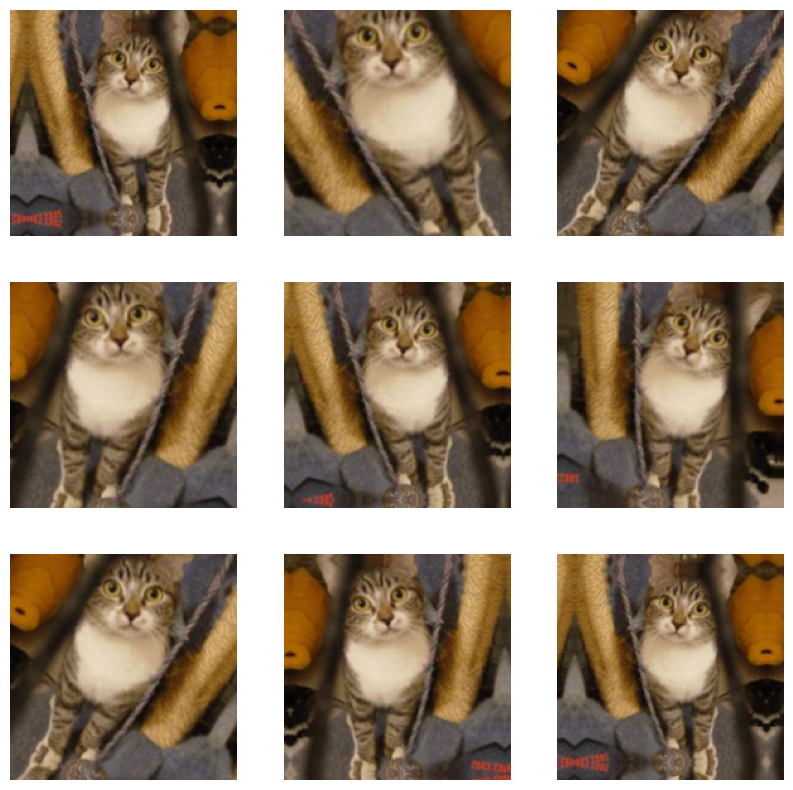

In [33]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),])

# Printing Augmented Images of a Random Input Image

plt.figure(figsize=(10, 10))
for images, _ in train_data_1.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [35]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [36]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True, 
        monitor="val_loss")
]

In [37]:
history = model.fit(
    train_data_1,
    epochs=30,
    validation_data = validation_data_1,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 226s 4s/step - loss: 0.7098 - accuracy: 0.5035 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 193s 3s/step - loss: 0.6912 - accuracy: 0.5195 - val_loss: 0.6774 - val_accuracy: 0.5950
Epoch 3/30
63/63 [==============================] - 208s 3s/step - loss: 0.6825 - accuracy: 0.5720 - val_loss: 0.6530 - val_accuracy: 0.5930
Epoch 4/30
63/63 [==============================] - 210s 3s/step - loss: 0.6597 - accuracy: 0.6030 - val_loss: 0.6144 - val_accuracy: 0.6760
Epoch 5/30
63/63 [==============================] - 207s 3s/step - loss: 0.6204 - accuracy: 0.6655 - val_loss: 0.5875 - val_accuracy: 0.6750
Epoch 6/30
63/63 [==============================] - 207s 3s/step - loss: 0.5887 - accuracy: 0.6940 - val_loss: 0.6242 - val_accuracy: 0.6440
Epoch 7/30
63/63 [==============================] - 205s 3s/step - loss: 0.5698 - accuracy: 0.6935 - val_loss: 0.5909 - val_accuracy: 0.6780
Epoch 8/30
63

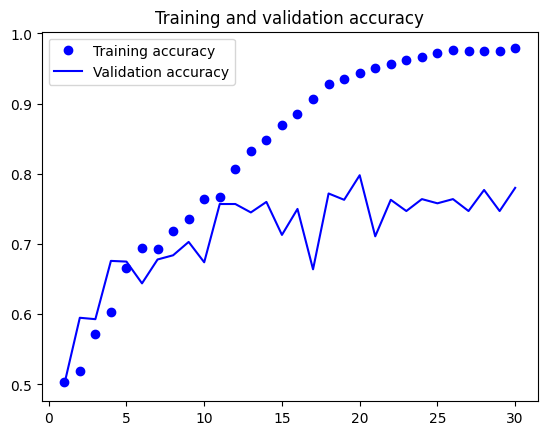

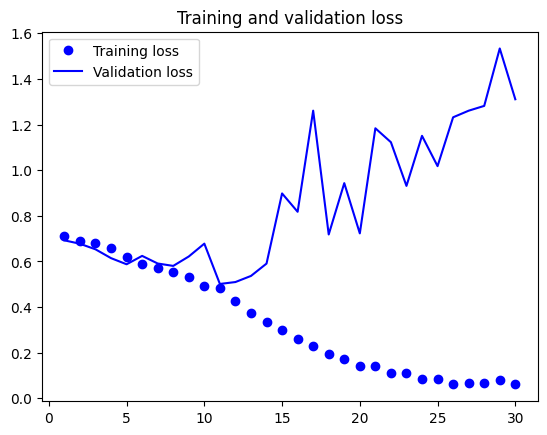

In [39]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [40]:
model.test = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = model.test.evaluate(test_data_1)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 25s 744ms/step - loss: 0.5715 - accuracy: 0.7280
Test accuracy: 0.728


In [41]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

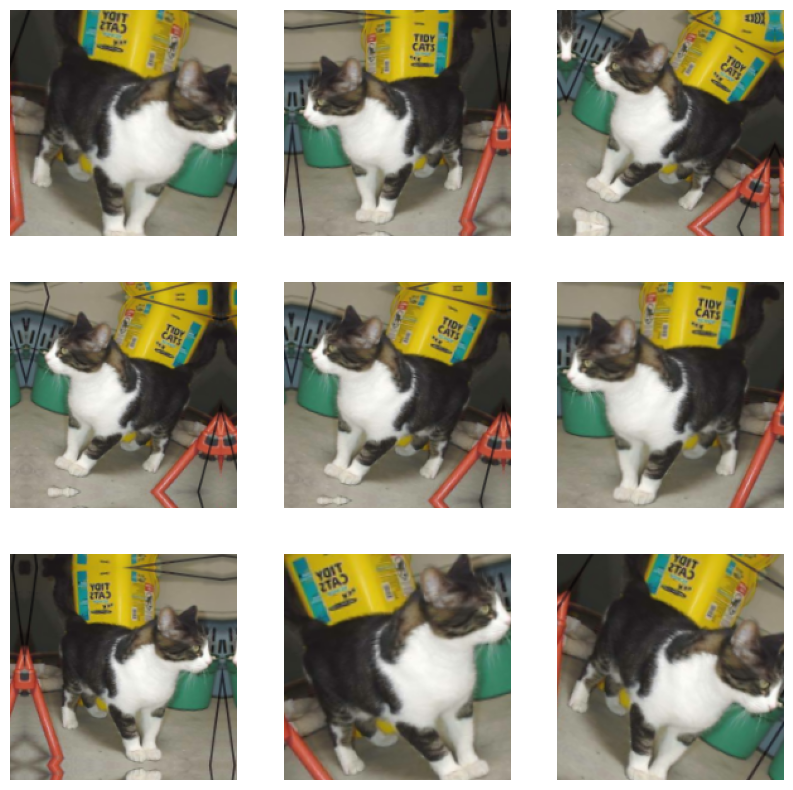

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_data_1.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [43]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [44]:
from tensorflow import keras
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [45]:
history = model.fit(
    train_data_1,
    epochs=50,
    validation_data=validation_data_1,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 222s 3s/step - loss: 0.6971 - accuracy: 0.5015 - val_loss: 0.6926 - val_accuracy: 0.6310
Epoch 2/50
63/63 [==============================] - 215s 3s/step - loss: 0.6908 - accuracy: 0.5155 - val_loss: 0.6765 - val_accuracy: 0.5680
Epoch 3/50
63/63 [==============================] - 216s 3s/step - loss: 0.6771 - accuracy: 0.5725 - val_loss: 0.7339 - val_accuracy: 0.5070
Epoch 4/50
63/63 [==============================] - 215s 3s/step - loss: 0.6650 - accuracy: 0.5755 - val_loss: 0.6527 - val_accuracy: 0.6140
Epoch 5/50
63/63 [==============================] - 218s 3s/step - loss: 0.6724 - accuracy: 0.5920 - val_loss: 0.6337 - val_accuracy: 0.6500
Epoch 6/50
63/63 [==============================] - 215s 3s/step - loss: 0.6511 - accuracy: 0.6460 - val_loss: 0.6430 - val_accuracy: 0.6040
Epoch 7/50
63/63 [==============================] - 214s 3s/step - loss: 0.6529 - accuracy: 0.6320 - val_loss: 0.7413 - val_accuracy: 0.5730
Epoch 8/50
63

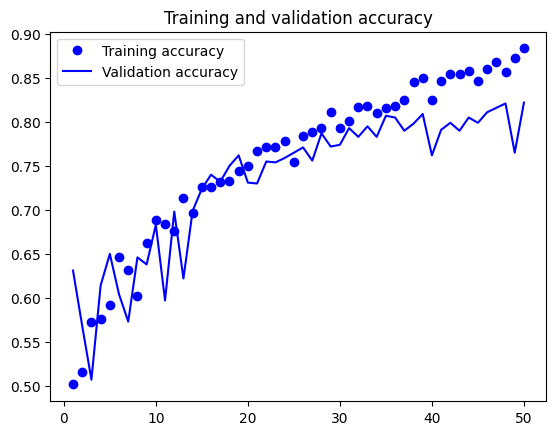

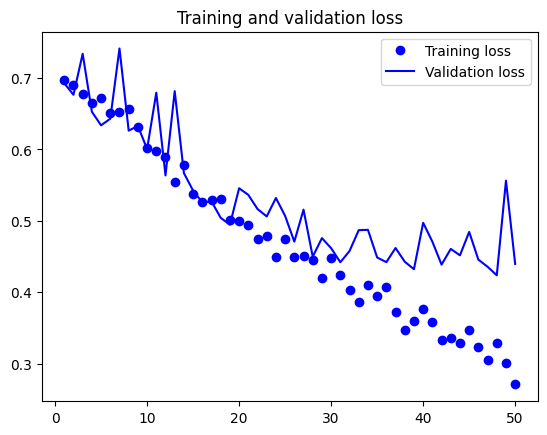

In [46]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


In [47]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_data_1)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 24s 723ms/step - loss: 0.4562 - accuracy: 0.8260
Test accuracy: 0.826


In [48]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [49]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [50]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_data_1,
    epochs=50,
    validation_data=validation_data_1,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 219s 3s/step - loss: 0.6956 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 214s 3s/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 217s 3s/step - loss: 0.6953 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 214s 3s/step - loss: 0.6932 - accuracy: 0.5145 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/50
63/63 [==============================] - 199s 3s/step - loss: 0.6947 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/50
63/63 [==============================] - 200s 3s/step - loss: 0.6925 - accuracy: 0.4950 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 7/50
63/63 [==============================] - 216s 3s/step - loss: 0.6930 - accuracy: 0.5185 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 8/50
63

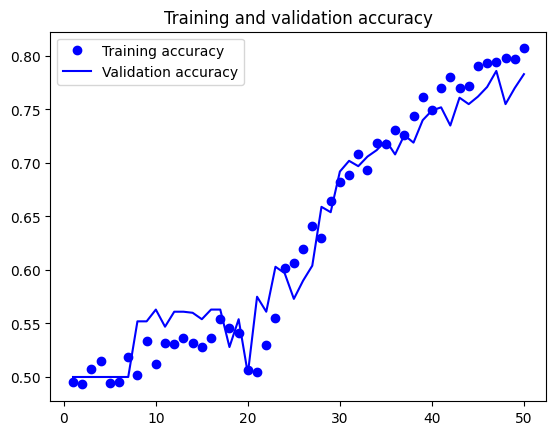

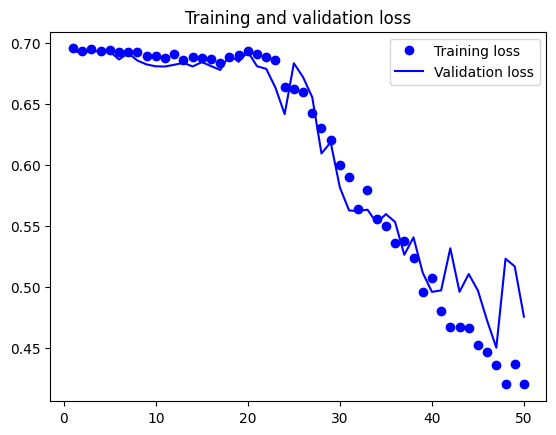

In [51]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [52]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_data_1)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 24s 727ms/step - loss: 0.5010 - accuracy: 0.7630
Test accuracy: 0.763


4

In [53]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.utils import image_dataset_from_directory


convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [54]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-4]:
    layer.trainable = False

In [55]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = convolution_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained = keras.Model(inputs, outputs)

In [56]:
model_pre_trained.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

In [57]:
early_stopping = EarlyStopping(patience=10)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping
]

In [58]:
history = model.fit(
    train_data_1,
    epochs=20,
    validation_data = validation_data_1,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 215s 3s/step - loss: 0.4301 - accuracy: 0.8010 - val_loss: 0.4627 - val_accuracy: 0.7810
Epoch 2/20
63/63 [==============================] - 219s 3s/step - loss: 0.3966 - accuracy: 0.8255 - val_loss: 0.4799 - val_accuracy: 0.7810
Epoch 3/20
63/63 [==============================] - 219s 3s/step - loss: 0.3842 - accuracy: 0.8235 - val_loss: 0.4484 - val_accuracy: 0.8030
Epoch 4/20
63/63 [==============================] - 217s 3s/step - loss: 0.3590 - accuracy: 0.8435 - val_loss: 0.4702 - val_accuracy: 0.7840
Epoch 5/20
63/63 [==============================] - 220s 3s/step - loss: 0.3789 - accuracy: 0.8270 - val_loss: 0.4205 - val_accuracy: 0.8140
Epoch 6/20
63/63 [==============================] - 201s 3s/step - loss: 0.3643 - accuracy: 0.8425 - val_loss: 0.4474 - val_accuracy: 0.7970
Epoch 7/20
63/63 [==============================] - 220s 3s/step - loss: 0.3542 - accuracy: 0.8495 - val_loss: 0.4697 - val_accuracy: 0.8090
Epoch 8/20
63

In [59]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_data_1)
print(f"Test accuracy: {test_acc:.3f}")
     

32/32 [==============================] - 23s 718ms/step - loss: 0.4570 - accuracy: 0.8140
Test accuracy: 0.814
